### MET triple modality autoencoder

In [1]:
import scipy.io as sio
import feather
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from functools import reduce
from collections import Counter
from cplAE_MET.utils.load_config import load_config
import cplAE_MET.utils.analysis_helpers as proc_utils


/home/fahimehb/miniconda3/envs/cplae_met/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pca_th = 0.9 

In [3]:
def set_paths(config_file=None):
    paths = load_config(config_file=config_file, verbose=False)

    paths['input'] = f'{str(paths["data_dir"])}'
    paths['arbor_density_file'] = f'{paths["input"]}/{str(paths["arbor_density_file"])}'
    # paths['arbor_density_PC_file'] = f'{paths["input"]}/{str(paths["arbor_density_PC_file"])}'
    paths['arbor_density_PC_vars_file'] = f'{paths["input"]}/{str(paths["arbor_density_PC_vars_file"])}'
    paths['ivscc_inh_m_features'] = f'{paths["input"]}/{str(paths["ivscc_inh_m_features"])}'
    paths['ivscc_exc_m_features'] = f'{paths["input"]}/{str(paths["ivscc_exc_m_features"])}'
    paths['fmost_exc_m_features'] = f'{paths["input"]}/{str(paths["fmost_exc_m_features"])}'


    paths['specimen_ids'] = f'{paths["input"]}/{str(paths["specimen_ids_file"])}'

    paths['E_timeseries'] = f'{paths["input"]}/{str(paths["E_timeseries_file"])}'
    paths['ipfx_features'] = f'{paths["input"]}/{str(paths["ipfx_features_file"])}'
    paths['e_output'] = f'{paths["input"]}/{str(paths["e_output_file"])}'
    paths['anno'] = f'{paths["input"]}/{str(paths["t_anno_output_file"])}'


    return paths


In [4]:
dir_pth = set_paths(config_file='config_preproc.toml')

...................................................
There are 8643 sample_ids in the locked dataset
...................................................
Loading M arbor_densities
Number of cells in arbor density file: 8643
...................................................
0 cells do not have arbor density data!
...................................................
keeping only ids that are inside specimen id list
In total remains this amount of cells: 8643
...................................................
masking each arbor density channel and putting each channel in one specific key of a dict
...................................................
create a 1d mask for each arbor density channel
...................................................
PCA analysis 


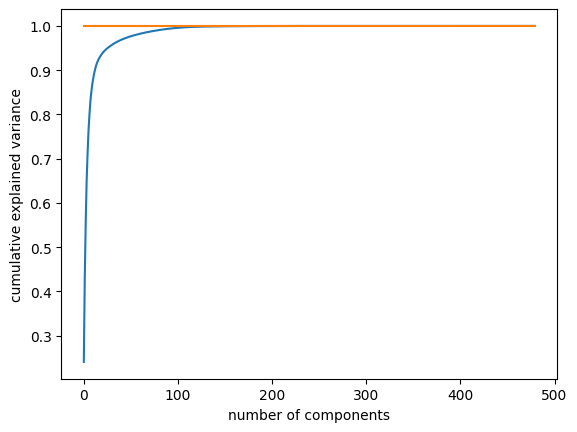

12


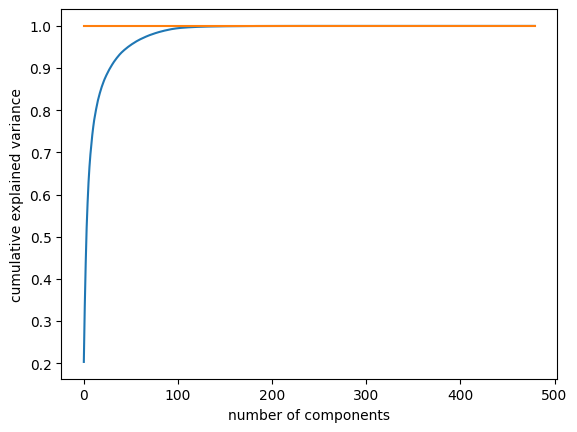

28


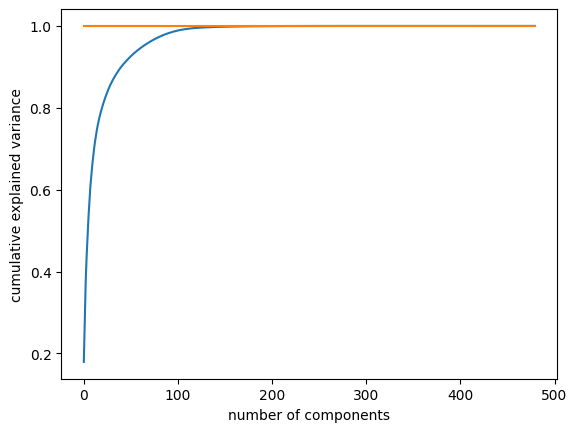

40


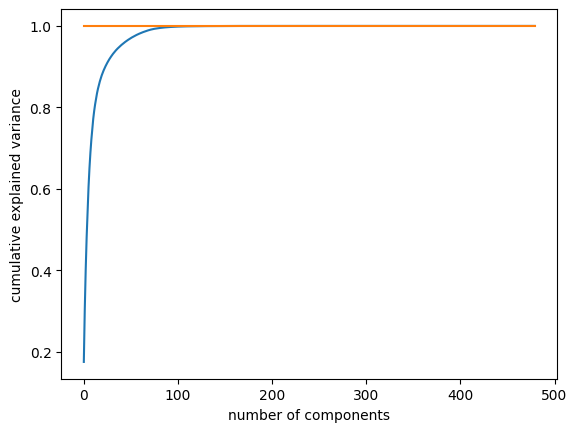

23
ax (971, 12)
de (971, 28)
api (1192, 40)
bas (1192, 23)
...................................................
Scaling PCA features


In [5]:
ids = pd.read_csv(dir_pth['specimen_ids'])
specimen_ids = ids['specimen_id'].tolist()
print("...................................................")
print("There are", len(specimen_ids), "sample_ids in the locked dataset")


print("...................................................")
print("Loading M arbor_densities")
m_input = sio.loadmat(dir_pth['arbor_density_file'])


arbor_ids = [mystr.rstrip() for mystr in m_input['specimen_id']]
print("Number of cells in arbor density file:", len(arbor_ids))

print("...................................................")
print(len([i for i in specimen_ids if i not in arbor_ids]), "cells do not have arbor density data!")

print("...................................................")
print("keeping only ids that are inside specimen id list")
mask_arbor_ids = [True if i in specimen_ids else False for i in arbor_ids]
arbor_ids = [b for a, b in zip(mask_arbor_ids, arbor_ids) if a]
print("In total remains this amount of cells:", sum(mask_arbor_ids))

print("...................................................")
print("masking each arbor density channel and putting each channel in one specific key of a dict")
soma_depth = np.squeeze(m_input['soma_depth'])[mask_arbor_ids]
arbor_density = {}
arbor_density['ax'] = m_input['hist_ax_de_api_bas'][:,:,:,0][mask_arbor_ids]
arbor_density['de'] = m_input['hist_ax_de_api_bas'][:,:,:,1][mask_arbor_ids]
arbor_density['api'] = m_input['hist_ax_de_api_bas'][:,:,:,2][mask_arbor_ids]
arbor_density['bas'] = m_input['hist_ax_de_api_bas'][:,:,:,3][mask_arbor_ids]

print("...................................................")
print("create a 1d mask for each arbor density channel")
# in the arbor density file, if a cell does not have M data, all the channels are nan values
# if a cell is exc, the ax and de (first two channels) are all zeros and the api and bas (second 
# two channels) have values. This mask is to find the exc cells with M data and inh cells with M data. 
# so if all channels are nan, then it will return False. 

not_valid_xm_channels = np.apply_over_axes(np.all, 
                                            np.logical_or(m_input['hist_ax_de_api_bas'] == 0, 
                                            np.isnan(m_input['hist_ax_de_api_bas'])),
                                            axes = [1, 2])
not_valid_xm_channels = np.squeeze(not_valid_xm_channels)
valid={}
valid['ax'] = ~not_valid_xm_channels[:,0]
valid['de']= ~not_valid_xm_channels[:,1]
valid['api'] = ~not_valid_xm_channels[:,2]
valid['bas']= ~not_valid_xm_channels[:,3]

# Now for each channel, we mask for the valid cells and then we look if there is any
# nan value in the cells arbor densities. If there is any nan, we should either 
# remove that cell or put that nan to zero for that channel
keep_cells = {}
for k in arbor_density.keys():
    # mask for the cells with arbor density
    arbor_density[k] = arbor_density[k][valid[k]]
    # Find the m_cells with that have nan values in their non-OFF channels
    keep_cells[k] = ~np.squeeze(np.apply_over_axes(np.any, np.isnan(arbor_density[k]),axes = [1, 2]))
    # remove the cells that have nan values in each channel
    arbor_density[k] = arbor_density[k][keep_cells[k]]
    # collapse the last to dim and have a 1d arbor density for each channel
    arbor_density[k] = arbor_density[k].reshape(arbor_density[k].shape[0], -1)


print("...................................................")
print("PCA analysis ")
n_comp_at_thr={}
for k in arbor_density.keys():
    n_comp_at_thr[k] = proc_utils.get_PCA_explained_variance_ratio_at_thr(nparray=arbor_density[k], threshold=pca_th)
    if n_comp_at_thr[k] == 0:
        n_comp_at_thr[k] = 1
    # if n_comp_at_thr[k]> 20:
    #     n_comp_at_thr[k] = 20

    print(n_comp_at_thr[k])

PC = {}
for k in arbor_density.keys():
    if k != "ids":
        pca = PCA(n_comp_at_thr[k])
        # PC[k] = pca.fit_transform(arbor_density[k])[:, :20]
        PC[k] = pca.fit_transform(arbor_density[k])

        print(k, PC[k].shape)

print("...................................................")
print("Scaling PCA features")
#Scaling PC features
Scaled_PCs = {}
total_var = pd.DataFrame(columns=PC.keys())

for k in PC.keys():
    v = np.sqrt(np.sum(pd.DataFrame(PC[k]).var(axis=0)))
    Scaled_PCs[k] = PC[k] / v
    total_var.loc[0, k] = v

# We save this cause we need them for the reconstruction of arbor densities
total_var.to_csv(dir_pth['arbor_density_PC_vars_file'], index=False)

In [6]:
1192 + 971

2163

...................................................
Removing outliers whithin 6 std from scaled PCs


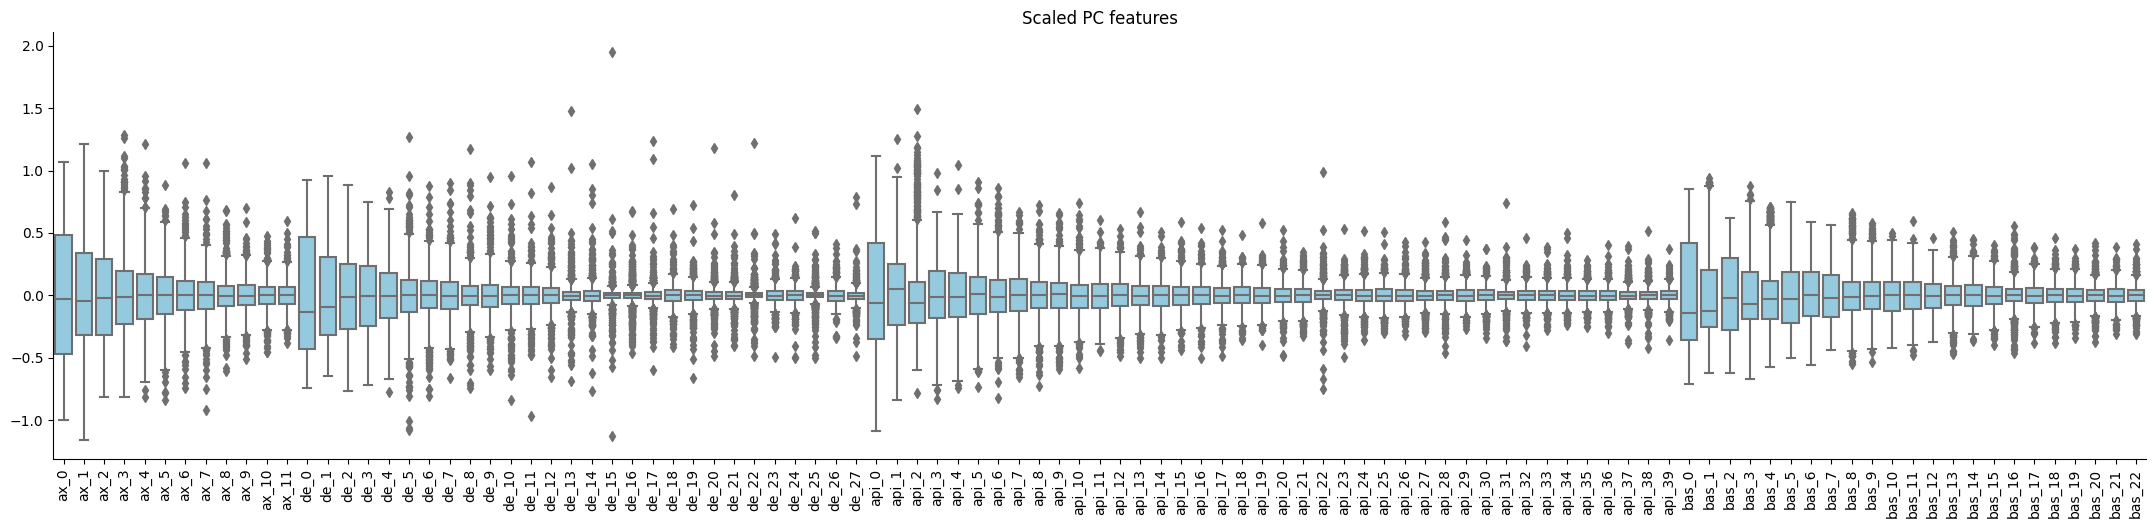

In [7]:
print("...................................................")
print("Removing outliers whithin 6 std from scaled PCs")
#attaching specimen ids and removing outliers
for k in PC.keys():
    Scaled_PCs[k] = pd.DataFrame(Scaled_PCs[k])
    scaling_thr = np.abs(np.max(Scaled_PCs[k].std(axis=0, skipna=True, numeric_only=True)) * 6)
    Scaled_PCs[k] = Scaled_PCs[k][(Scaled_PCs[k] < scaling_thr) & (Scaled_PCs[k] > -1 * scaling_thr)]
    Scaled_PCs[k].columns = [k + "_" + str(i) for i in range(Scaled_PCs[k].shape[1])]
    valid_ids = [id for i, id in enumerate(arbor_ids) if valid[k][i]]
    valid_ids = [id for i, id in enumerate(valid_ids) if keep_cells[k][i]]
    Scaled_PCs[k]["specimen_id"] = valid_ids
    Scaled_PCs[k]['specimen_id'] = Scaled_PCs[k]['specimen_id'].astype(str)

#Merge all scaled PC features into one df
data_frames = []
for k in Scaled_PCs.keys():
    data_frames.append(Scaled_PCs[k])

Scaled_PCs = reduce(lambda left, right: pd.merge(left, right, on=['specimen_id'], how='outer'), data_frames)

df = Scaled_PCs.melt(value_vars=Scaled_PCs[[c for c in Scaled_PCs.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value", kind='box', data=df, palette=sns.color_palette(["skyblue"]), aspect=4.4)
ax = plt.gca()
ax.set(**{'title': 'Scaled PC features', 'xlabel': '', 'ylabel': ''})
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [8]:
Scaled_PCs.head()

ax_0      ax_1      ax_2      ax_3      ax_4      ax_5      ax_6  \
0  0.372486 -0.870501  0.656789  0.559691  0.015270 -0.393066 -0.522451   
1  0.543691 -0.658797  0.400675  0.209574  0.035748 -0.087930  0.006088   
2  0.074588 -0.587531  0.479398  0.889335  0.696152  0.452523  0.418432   
3  0.315092 -0.814781  0.619308  0.594778  0.083412 -0.293300 -0.420015   
4  0.413268 -0.812997  0.558930  0.490170  0.161364 -0.086442 -0.016717   

       ax_7      ax_8      ax_9  ...  bas_13  bas_14 bas_15  bas_16  bas_17  \
0  0.615011  0.305465  0.207428  ...     NaN     NaN    NaN     NaN     NaN   
1  0.131846  0.102428  0.197217  ...     NaN     NaN    NaN     NaN     NaN   
2 -0.336880 -0.151069 -0.104850  ...     NaN     NaN    NaN     NaN     NaN   
3  0.486284  0.233602  0.106542  ...     NaN     NaN    NaN     NaN     NaN   
4  0.043493 -0.042935 -0.078563  ...     NaN     NaN    NaN     NaN     NaN   

   bas_18  bas_19  bas_20  bas_21  bas_22  
0     NaN     NaN     NaN     NaN     NaN  
1     NaN     NaN     NaN     NaN     NaN  
2     NaN     NaN     NaN     NaN     NaN  
3     NaN     NaN     NaN     NaN     NaN  
4     NaN     NaN     NaN     NaN     NaN  

[5 rows x 104 columns]

In [9]:
# read M_metadata 
ivscc_inh = pd.read_csv(dir_pth['ivscc_inh_m_features'])
ivscc_exc = pd.read_csv(dir_pth['ivscc_exc_m_features']) 
fmost_mf = pd.read_csv(dir_pth['fmost_exc_m_features'])  

In [10]:
Scaled_PCs

ax_0      ax_1      ax_2      ax_3      ax_4      ax_5      ax_6  \
0     0.372486 -0.870501  0.656789  0.559691  0.015270 -0.393066 -0.522451   
1     0.543691 -0.658797  0.400675  0.209574  0.035748 -0.087930  0.006088   
2     0.074588 -0.587531  0.479398  0.889335  0.696152  0.452523  0.418432   
3     0.315092 -0.814781  0.619308  0.594778  0.083412 -0.293300 -0.420015   
4     0.413268 -0.812997  0.558930  0.490170  0.161364 -0.086442 -0.016717   
...        ...       ...       ...       ...       ...       ...       ...   
2158       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2159       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2160       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2161       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2162       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

          ax_7      ax_8      ax_9  ...    bas_13    bas_14    bas_15  \
0     0.615011  0.305465  0.207428  ...       NaN       NaN       NaN   
1     0.131846  0.102428  0.197217  ...       NaN       NaN       NaN   
2    -0.336880 -0.151069 -0.104850  ...       NaN       NaN       NaN   
3     0.486284  0.233602  0.106542  ...       NaN       NaN       NaN   
4     0.043493 -0.042935 -0.078563  ...       NaN       NaN       NaN   
...        ...       ...       ...  ...       ...       ...       ...   
2158       NaN       NaN       NaN  ...  0.268328  0.352694  0.228633   
2159       NaN       NaN       NaN  ...  0.012464 -0.061309  0.004849   
2160       NaN       NaN       NaN  ...  0.042399  0.018709 -0.072463   
2161       NaN       NaN       NaN  ...  0.242526  0.354385  0.152786   
2162       NaN       NaN       NaN  ... -0.445579  0.273882 -0.221503   

        bas_16    bas_17    bas_18    bas_19    bas_20    bas_21    bas_22  
0          NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1          NaN       NaN       NaN       NaN       NaN       NaN       NaN  
2          NaN       NaN       NaN       NaN       NaN       NaN       NaN  
3          NaN       NaN       NaN       NaN       NaN       NaN       NaN  
4          NaN       NaN       NaN       NaN       NaN       NaN       NaN  
...        ...       ...       ...       ...       ...       ...       ...  
2158  0.483334  0.088959 -0.029254 -0.048779  0.222119  0.154334 -0.090431  
2159  0.024120 -0.063642  0.007013  0.052861  0.012100  0.011667  0.020186  
2160  0.000550  0.048384  0.027655 -0.025124 -0.052465  0.059482 -0.069031  
2161 -0.048288 -0.167318  0.295800 -0.085439 -0.151412 -0.175287  0.106528  
2162  0.100990 -0.193829 -0.138617 -0.182494 -0.072975  0.141067  0.183115  

[2163 rows x 104 columns]

In [21]:
m_cells_w_feature = [str(i) for i in ivscc_inh.specimen_id.to_list() + fmost_mf.specimen_id.to_list() + ivscc_exc.specimen_id.to_list()]
m_cells_w_arborPCs = [str(i) for i in Scaled_PCs['specimen_id'].to_list()]

print("m_cells with m features:", len(m_cells_w_feature))
print("m_cells with arbor PCs:", len(m_cells_w_arborPCs))

print("m cells with features that are NOT in m cells with arbor PCs:",len([i for i in m_cells_w_feature if i not in m_cells_w_arborPCs]))
print("m cells with features that are NOT in locked dataset:", len([i for i in m_cells_w_feature if i not in ids.specimen_id.to_list()]))


print("so we expect to see this amount of cells with either m features or m arbor PCs:", len([i for i in m_cells_w_feature if i not in m_cells_w_arborPCs]) + 
                                                                                         len(m_cells_w_arborPCs) - 
                                                                                         len([i for i in m_cells_w_feature if i not in ids.specimen_id.to_list()]))

m_cells with m features: 1932
m_cells with arbor PCs: 2163
m cells with features that are NOT in m cells with arbor PCs: 272
m cells with features that are NOT in locked dataset: 207
so we expect to see this amount of cells with either m features or m arbor PCs: 2228


### Inh cells features

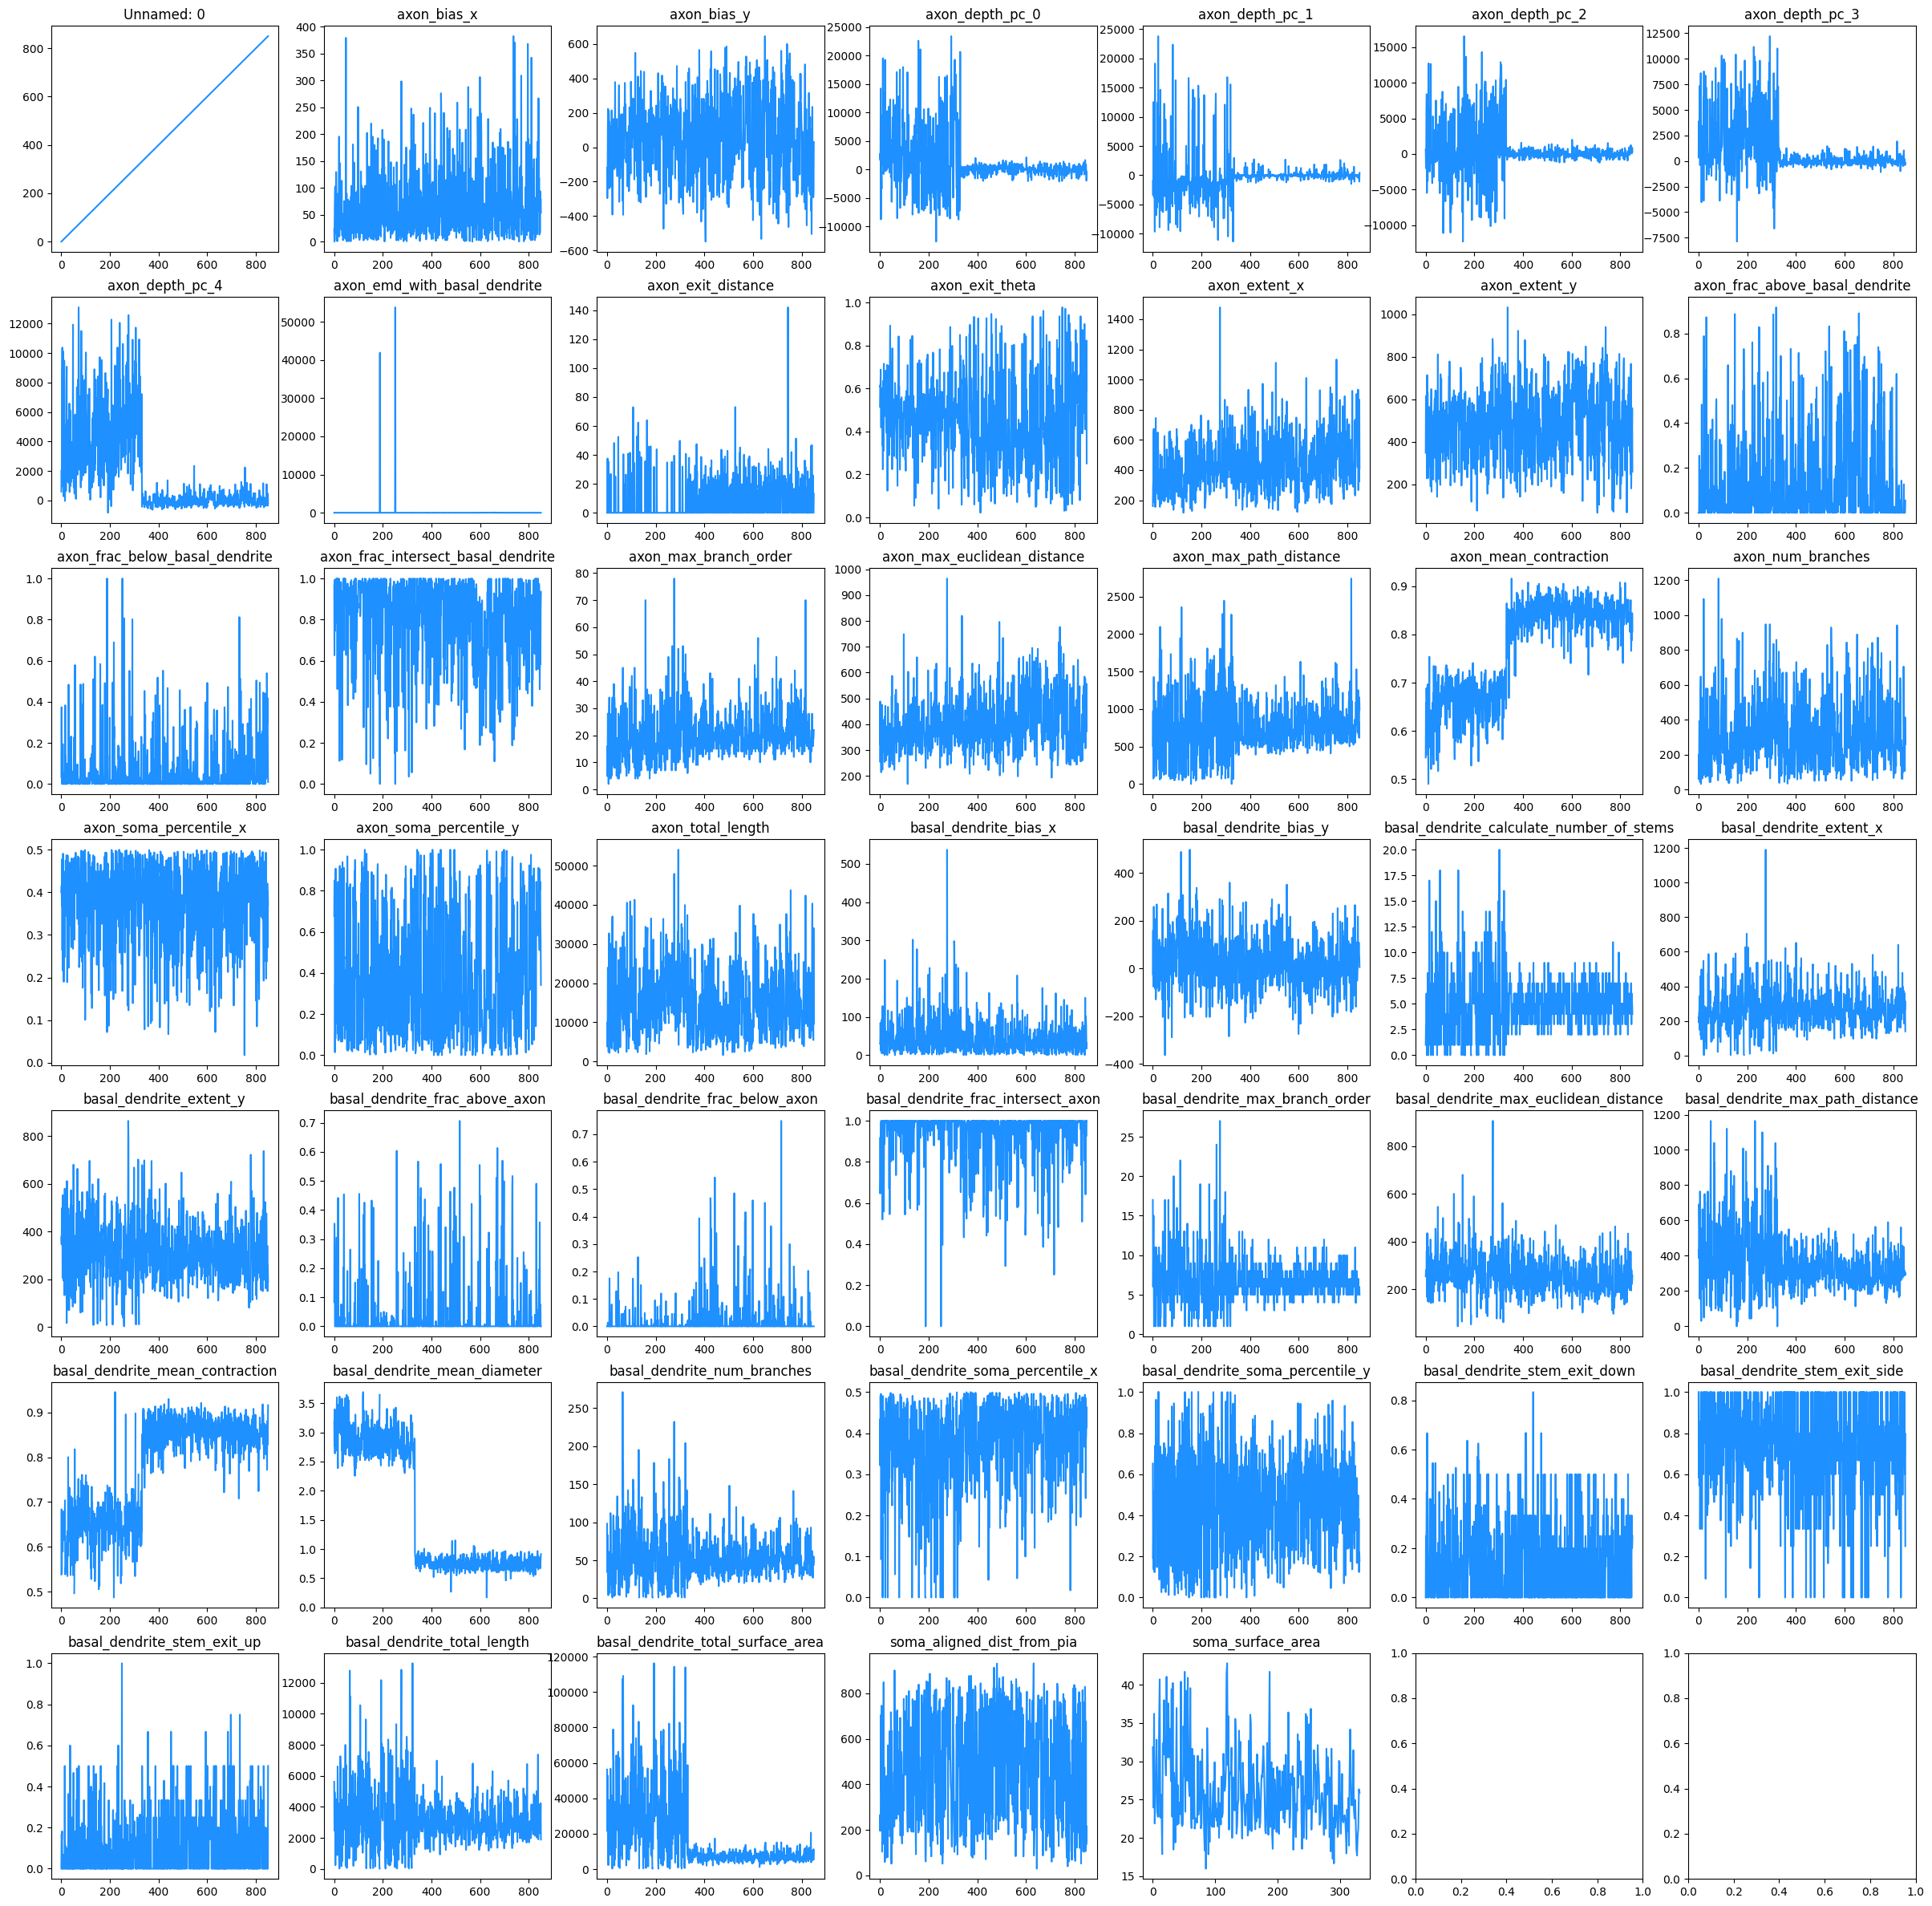

In [15]:
fig, axs = plt.subplots(7,7, figsize=(30, 30))
for ax, feature in zip(axs.flatten(), [i for i in ivscc_inh.columns if i!="specimen_id"]):
    ax.plot(ivscc_inh[feature], color='dodgerblue')
    ax.set_title(feature)

### Exc cells features

In [16]:
ivscc_exc.head()

Unnamed: 0  specimen_id  apical_dendrite_bias_x  apical_dendrite_bias_y  \
0           0    586071558               15.640472              560.457128   
1           1    587062666               79.832357              512.398427   
2           2    589716891              104.783264              577.102263   
3           3    589754504                0.102719               70.813969   
4           4    596995044               48.084711              591.383293   

   apical_dendrite_depth_pc_0  apical_dendrite_depth_pc_1  \
0                  114.138461                    9.920419   
1                   49.675234                    0.431590   
2                   64.075500                   -9.270648   
3                  -11.217564                  -14.783886   
4                   17.624717                  -57.727757   

   apical_dendrite_depth_pc_2  apical_dendrite_depth_pc_3  \
0                   38.424189                  -30.054454   
1                   26.593156                  -65.152302   
2                   41.876505                  -25.428638   
3                   18.785130                    5.232744   
4                   69.308145                  -21.146008   

   apical_dendrite_early_branch_path  apical_dendrite_emd_with_basal_dendrite  \
0                           0.556559                                63.294199   
1                           1.258455                                44.541769   
2                           0.631016                                63.050652   
3                           0.632779                                10.314850   
4                           0.182827                                33.485238   

   ...  basal_dendrite_num_branches  basal_dendrite_soma_percentile_x  \
0  ...                         16.0                          0.419355   
1  ...                         29.0                          0.462483   
2  ...                         15.0                          0.000000   
3  ...                         18.0                          0.459016   
4  ...                         20.0                          0.485263   

   basal_dendrite_soma_percentile_y  basal_dendrite_stem_exit_down  \
0                          0.659323                       0.000000   
1                          0.687585                       0.000000   
2                          0.771772                       0.000000   
3                          0.800546                       0.000000   
4                          0.650526                       0.142857   

   basal_dendrite_stem_exit_side  basal_dendrite_stem_exit_up  \
0                       0.833333                     0.166667   
1                       1.000000                     0.000000   
2                       1.000000                     0.000000   
3                       1.000000                     0.000000   
4                       0.571429                     0.285714   

   basal_dendrite_total_length  basal_dendrite_total_surface_area  \
0                  1596.996207                        6516.402249   
1                  2710.195284                       28412.544422   
2                  1234.382303                       11339.125504   
3                  1630.137681                       16149.448618   
4                   977.547590                        5058.323976   

   soma_aligned_dist_from_pia  soma_surface_area  
0                  545.513147         409.064298  
1                  515.275722        1180.761194  
2                  566.147737         421.849971  
3                  690.497947         783.824828  
4                  679.123288         183.652931  

[5 rows x 53 columns]

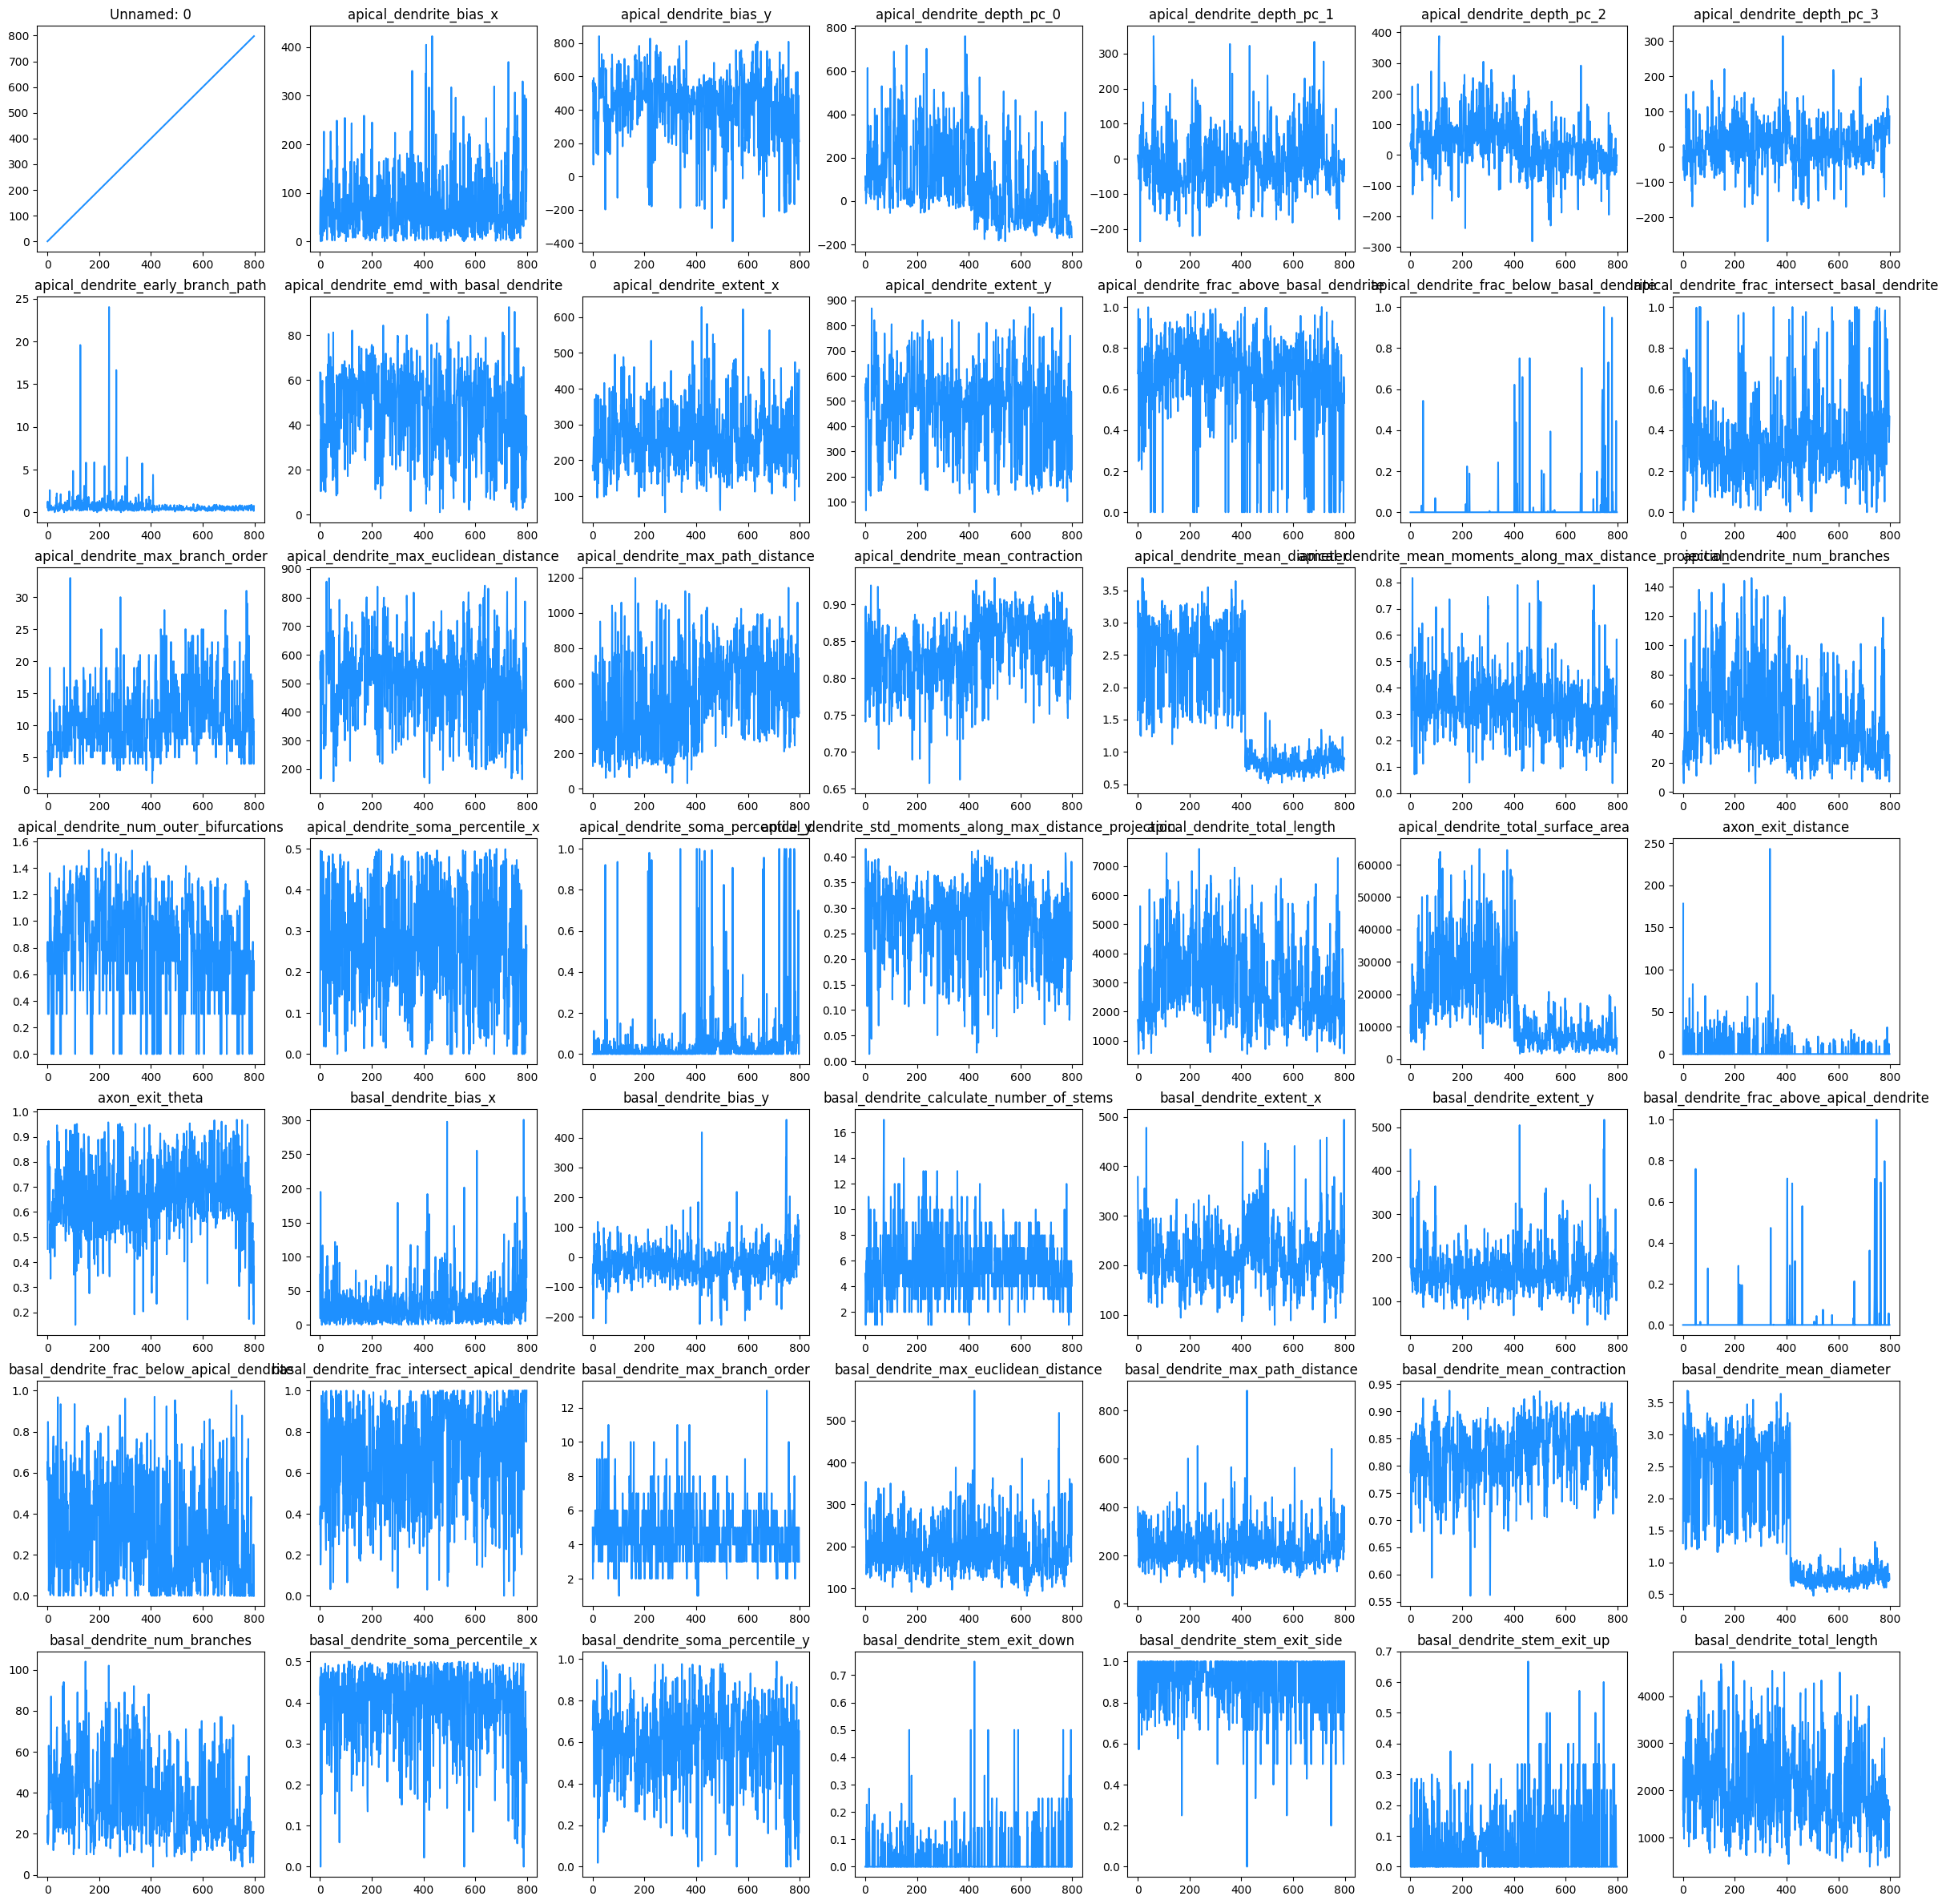

In [17]:
fig, axs = plt.subplots(7,7, figsize=(30, 30))
for ax, feature in zip(axs.flatten(), [i for i in ivscc_exc.columns if i!="specimen_id"]):
    ax.plot(ivscc_exc[feature], color='dodgerblue')
    ax.set_title(feature)

### fMOST M features

In [18]:
fmost_mf.head()

Unnamed: 0                  specimen_id  apical_dendrite_bias_x  \
0           0   17109_6201-X4328-Y6753_reg                148.6700   
1           1  17109_6301-X4756-Y24516_reg                 83.5906   
2           2   17109_6601-X4384-Y7436_reg                     NaN   
3           3  17109_6601-X5417-Y25287_reg                 15.1209   
4           4   17109_6801-X7432-Y4405_reg                120.2471   

   apical_dendrite_bias_y  apical_dendrite_depth_pc_0  \
0                 35.7091                  -26.319656   
1                 25.7496                  -24.016929   
2                     NaN                    0.000000   
3               -154.7340                  -47.542648   
4               -197.5790                  -27.598021   

   apical_dendrite_depth_pc_1  apical_dendrite_depth_pc_2  \
0                  -26.521676                   16.411191   
1                  -23.520326                    9.768680   
2                    0.000000                    0.000000   
3                  -40.904532                   -1.891232   
4                  -32.906300                   31.485929   

   apical_dendrite_depth_pc_3  apical_dendrite_early_branch_path  \
0                   31.901829                           0.824205   
1                   34.725255                           0.484827   
2                    0.000000                                NaN   
3                   90.340870                           0.631446   
4                   29.624960                           0.415617   

   apical_dendrite_emd_with_basal_dendrite  ...  basal_dendrite_num_branches  \
0                                 7.794209  ...                         18.0   
1                                 4.484431  ...                         31.0   
2                              1963.000000  ...                         47.0   
3                                20.535911  ...                         34.0   
4                                12.975269  ...                         42.0   

   basal_dendrite_soma_percentile_x  basal_dendrite_soma_percentile_y  \
0                          0.059259                          0.344444   
1                          0.346226                          0.344340   
2                          0.366220                          0.473995   
3                          0.441919                          0.327020   
4                          0.443077                          0.555897   

   basal_dendrite_stem_exit_down  basal_dendrite_stem_exit_side  \
0                       0.500000                       0.500000   
1                       0.333333                       0.333333   
2                       0.333333                       0.333333   
3                       0.000000                       1.000000   
4                       0.000000                       0.750000   

   basal_dendrite_stem_exit_up  basal_dendrite_total_length  \
0                     0.000000                  1119.417870   
1                     0.333333                  1463.648621   
2                     0.333333                  2557.240216   
3                     0.000000                  2191.587034   
4                     0.250000                  2695.833164   

   basal_dendrite_total_surface_area  soma_aligned_dist_from_pia  \
0                        6983.667606                     777.531   
1                        9097.721238                     802.251   
2                       15087.851071                     749.577   
3                       13482.614995                     771.865   
4                       16810.061927                     637.755   

   soma_surface_area  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  

[5 rows x 53 columns]

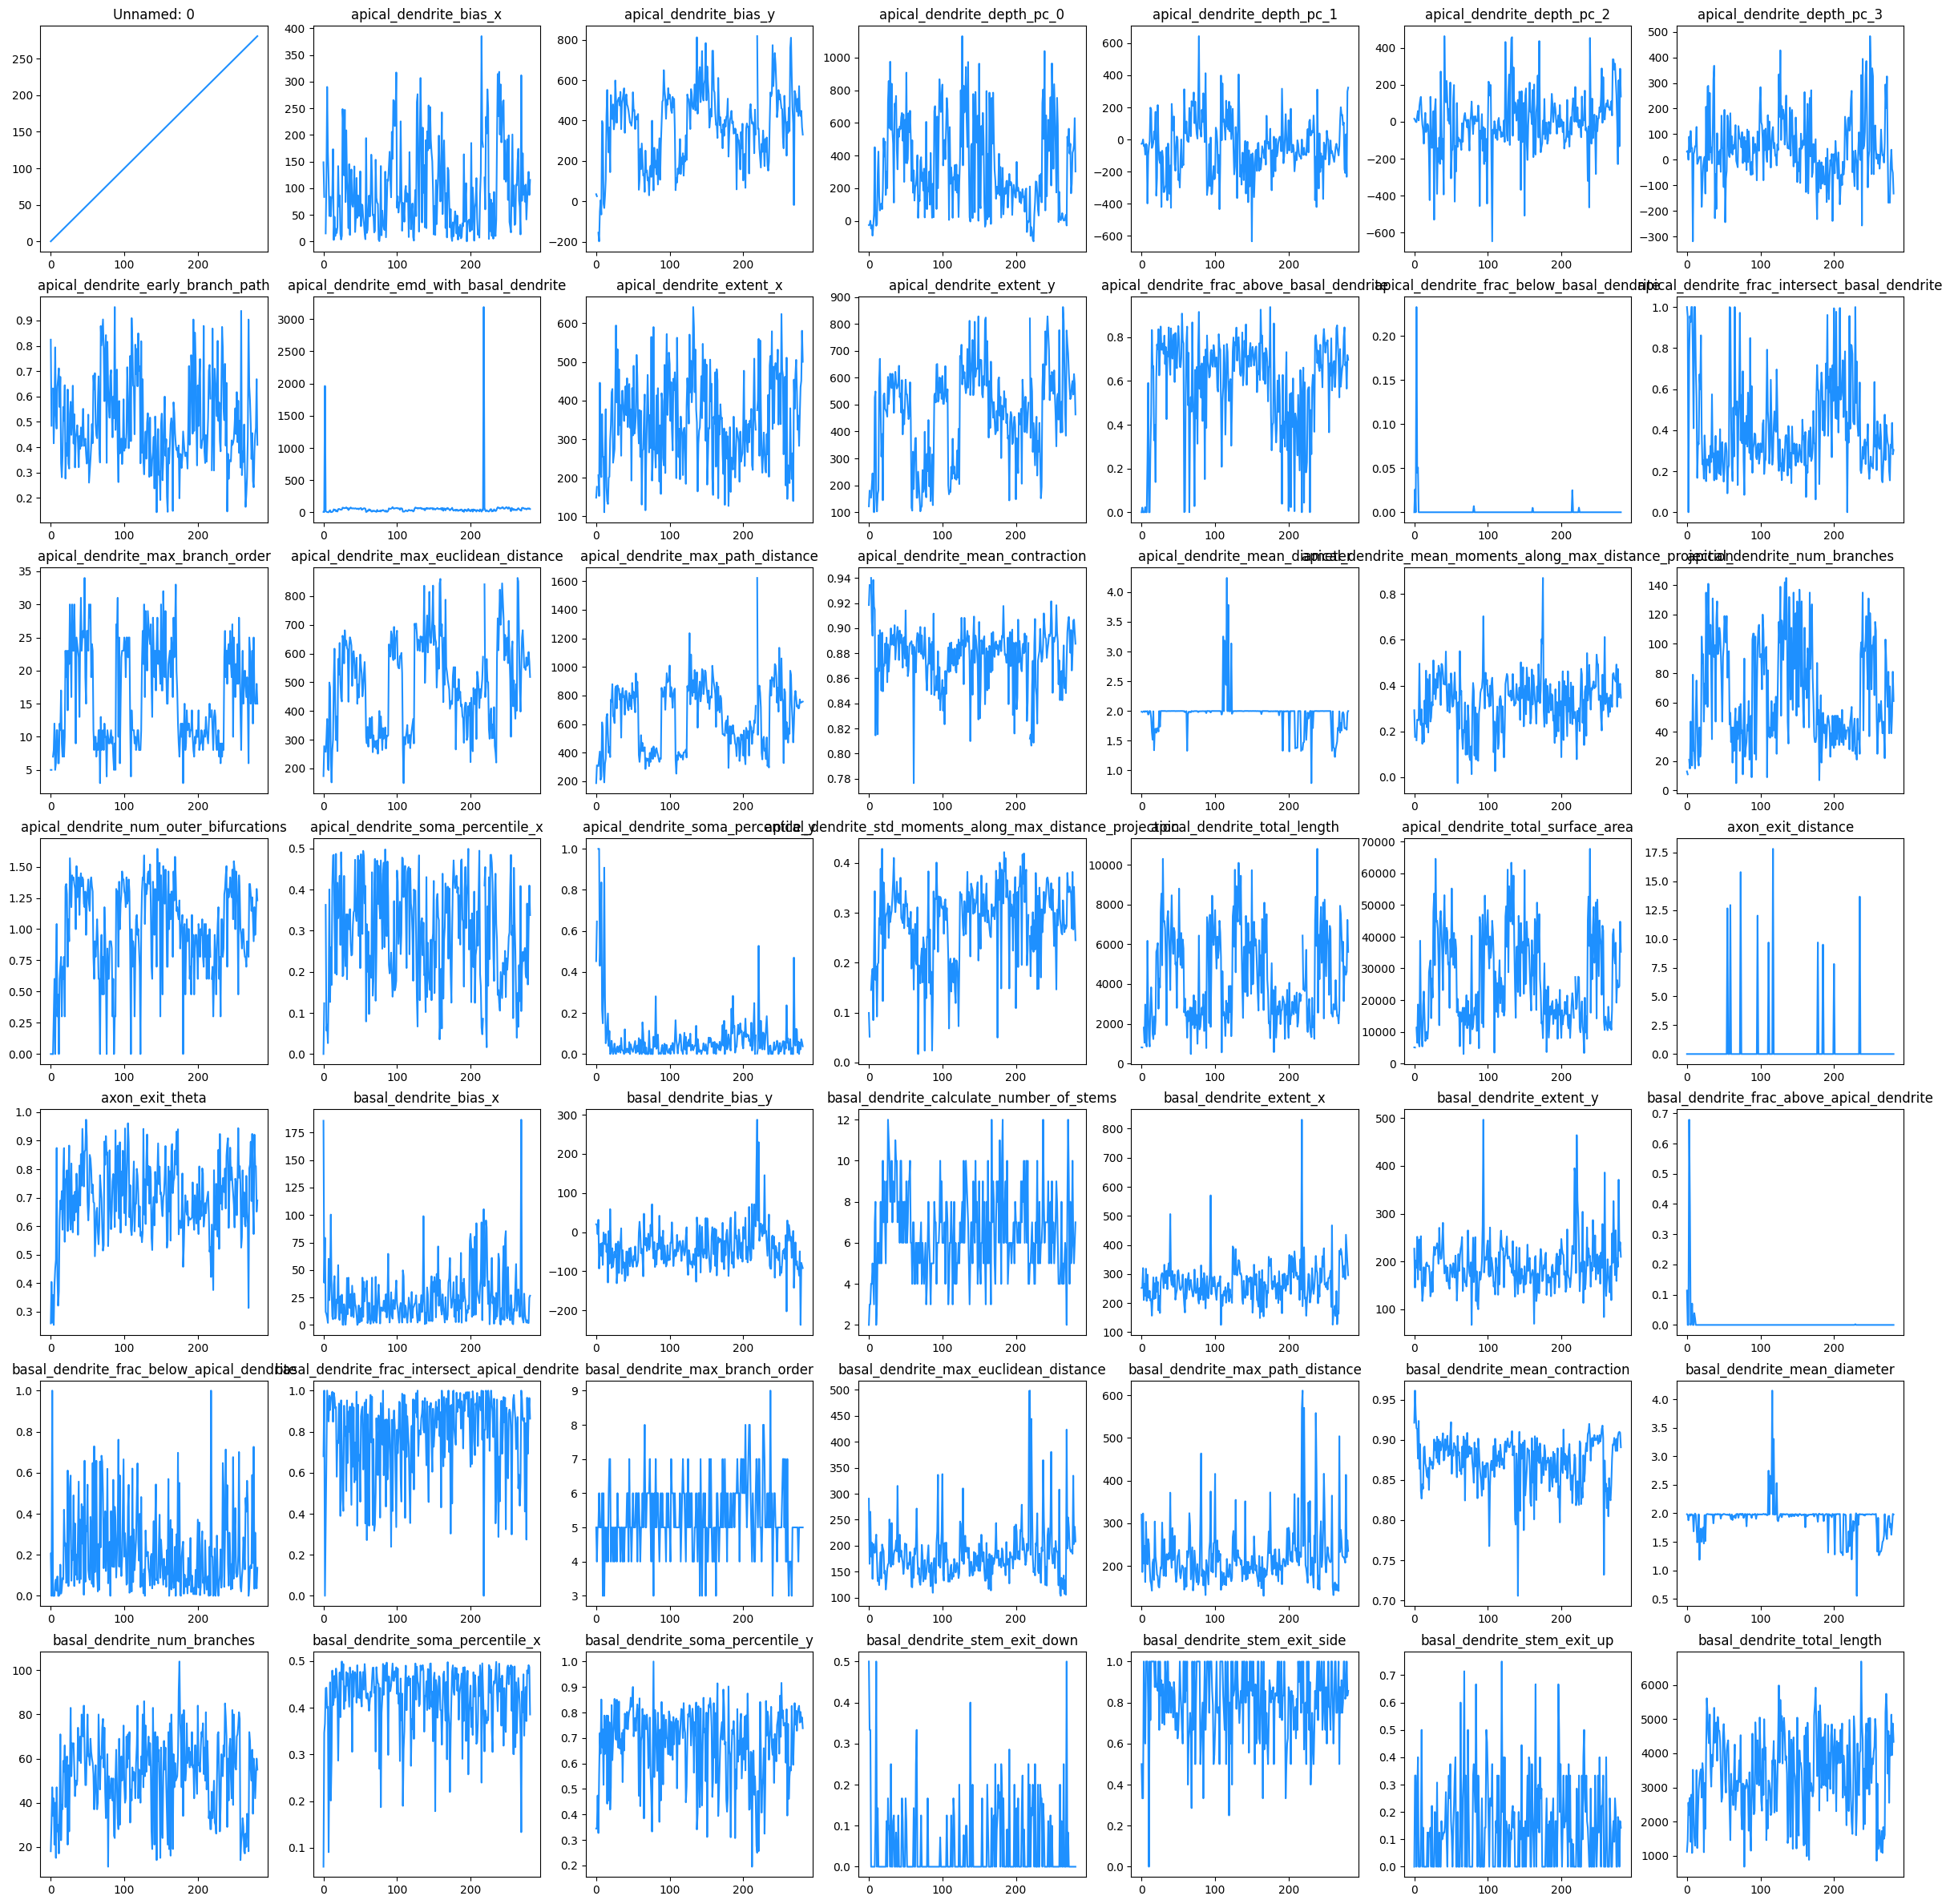

In [19]:
fig, axs = plt.subplots(7,7, figsize=(30, 30))
for ax, feature in zip(axs.flatten(), [i for i in fmost_mf.columns if i!="specimen_id"]):
    ax.plot(fmost_mf[feature], color='dodgerblue')
    ax.set_title(feature)

### Reliable features to keep:

In [22]:
m_features = {"exc": ["specimen_id",
                      "apical_dendrite_max_euclidean_distance",
                      "apical_dendrite_bias_y",
                      "apical_dendrite_extent_y",
                      "apical_dendrite_soma_percentile_y",
                      "apical_dendrite_emd_with_basal_dendrite",
                      "apical_dendrite_frac_below_basal_dendrite",
                      "basal_dendrite_frac_above_apical_dendrite",
                      "apical_dendrite_depth_pc_0",
                      "apical_dendrite_total_length",
                      "basal_dendrite_bias_y",
                      "apical_dendrite_frac_above_basal_dendrite",
                      "basal_dendrite_soma_percentile_y",
                      "basal_dendrite_max_euclidean_distance",
                      "apical_dendrite_frac_intersect_basal_dendrite",
                      "basal_dendrite_extent_y",
                      "apical_dendrite_depth_pc_1",
                      "apical_dendrite_num_branches",
                      "apical_dendrite_extent_x",
                      "basal_dendrite_extent_x",
                      "basal_dendrite_total_length"],
                      
              "inh": ["specimen_id",
                      "basal_dendrite_max_euclidean_distance",
                      "basal_dendrite_bias_y",
                      "basal_dendrite_extent_y",
                      "basal_dendrite_soma_percentile_y",
                      "axon_emd_with_basal_dendrite",
                      "basal_dendrite_frac_below_axon",
                      "basal_dendrite_frac_above_axon",
                      "basal_dendrite_total_length",
                      "basal_dendrite_frac_intersect_axon",
                      "basal_dendrite_num_branches",
                      "basal_dendrite_extent_x"]}

In [23]:
print("...................................................")
print("size of ivscc_exc, inh and fmost file before filtering for columns and rows")
print(ivscc_exc.shape, ivscc_inh.shape, fmost_mf.shape)

...................................................
size of ivscc_exc, inh and fmost file before filtering for columns and rows
(799, 53) (851, 48) (282, 53)


### Keep locked cells and reliable features from ivscc exc/inh and fmost data

In [24]:
# Keep locked cells and reliable features from ivscc exc/inh and fmost data
ivscc_exc['specimen_id'] = ivscc_exc['specimen_id'].astype(str)
ivscc_inh['specimen_id'] = ivscc_inh['specimen_id'].astype(str)
fmost_mf['specimen_id'] = fmost_mf['specimen_id'].astype(str)

ivscc_exc = ivscc_exc[ivscc_exc['specimen_id'].isin(ids['specimen_id'].to_list())]
ivscc_inh = ivscc_inh[ivscc_inh['specimen_id'].isin(ids['specimen_id'].to_list())]
fmost_mf = fmost_mf[fmost_mf['specimen_id'].isin(ids['specimen_id'].to_list())]

fmost_mf = fmost_mf[m_features['exc']]
ivscc_exc = ivscc_exc[m_features['exc']]
ivscc_inh = ivscc_inh[m_features['inh']]

In [25]:
print("...................................................")
print("size of ivscc_exc, inh and fmost file after filtering for columns and rows")
print(ivscc_exc.shape, ivscc_inh.shape, fmost_mf.shape)

...................................................
size of ivscc_exc, inh and fmost file after filtering for columns and rows
(772, 21) (826, 12) (127, 21)


### concat fmost, ivscc_inh and ivscc_exc features into a dataframe

In [29]:
data_frames = [ivscc_exc, fmost_mf, ivscc_inh]
m_features = reduce(lambda left, right: pd.merge(left, right, how='outer'), data_frames)
m_features['specimen_id'] = m_features['specimen_id'].astype(str)


In [30]:
m_features.shape

(1725, 26)

...................................................
Zscoring mfeatures features


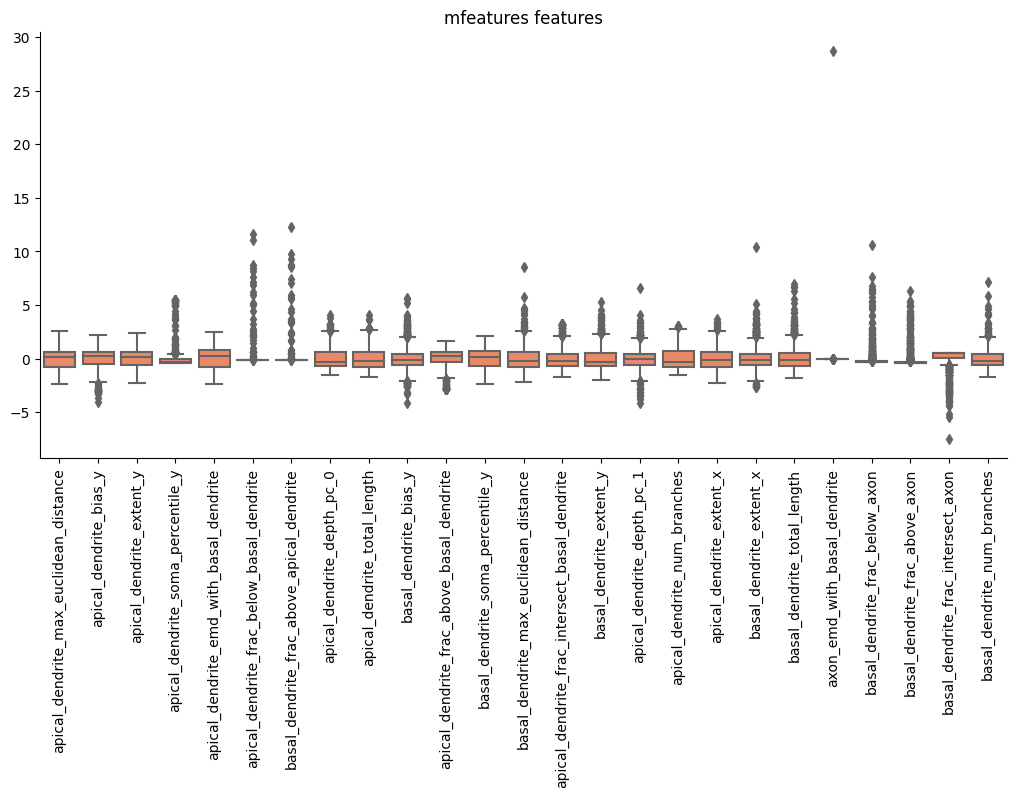

Removing extreme mfeatures values (within 6 std)


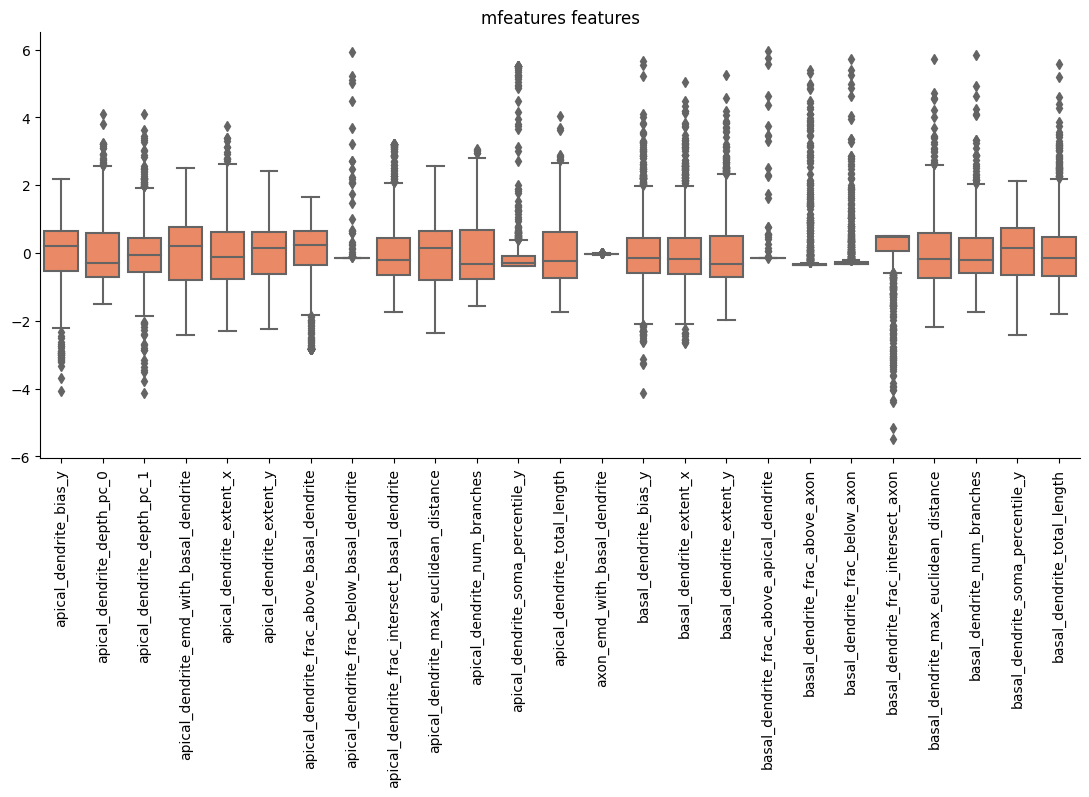

In [27]:
print("...................................................")
print("Zscoring mfeatures features")
subset_m_features = m_features[[c for c in m_features.columns if c != "specimen_id"]]
m_features_norm = (subset_m_features - subset_m_features.mean(axis=0)) / subset_m_features.std(axis=0)

df = m_features_norm.melt(value_vars=m_features_norm[[c for c in m_features_norm.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value", kind='box', data=df, palette=sns.color_palette(["coral"]),aspect=2.4)
ax = plt.gca()
ax.set(**{'title': 'mfeatures features', 'xlabel': '', 'ylabel':''})
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

print("Removing extreme mfeatures values (within 6 std)")
scaling_thr = m_features_norm.std(axis=0, skipna=True, numeric_only=True) * 6
m_features_norm = m_features_norm.reset_index()
df1 = pd.melt(m_features_norm, id_vars=['index'], value_vars=[c for c in m_features_norm if c != "index"])
df2 = pd.DataFrame(scaling_thr).reset_index().rename(columns={"index": 'variable', 0:"thr_std"})
df3 = df1.merge(df2, on="variable")
df3['new_value'] = np.where((df3['value'] < df3['thr_std']) & (df3['value'] > -1 * df3['thr_std'])
                        , df3['value'], np.nan)
m_features_norm = df3.pivot(index='index', columns="variable", values="new_value")
m_features_norm['specimen_id'] = m_features['specimen_id'].astype(str)

df = m_features_norm.melt(value_vars=m_features_norm[[c for c in m_features_norm.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value", kind='box', data=df, palette=sns.color_palette(["coral"]),aspect=2.4)
ax = plt.gca()
ax.set(**{'title': 'mfeatures features', 'xlabel': '', 'ylabel':''})
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()


### Merge scaled pcs with m features

In [64]:
print("Scaled PCs size:", Scaled_PCs.shape)
print("...................................................")
print("adding soma depth and other m features to M data")
m_cells = ~np.isnan(soma_depth)
m_cells = [id for i, id in enumerate(arbor_ids) if m_cells[i]]

sd = pd.DataFrame({"specimen_id": m_cells, "soma_depth": soma_depth[~np.isnan(soma_depth)]})

data_frames = [Scaled_PCs, sd, m_features_norm]
df_merged = reduce(lambda left, right: pd.merge(left, right, on=['specimen_id'], how='outer'), data_frames)
df_merged = df_merged.merge(pd.DataFrame(specimen_ids, columns=["specimen_id"]), on="specimen_id", how='right')

Scaled PCs size: (2163, 104)
...................................................
adding soma depth and other m features to M data


In [65]:
print("...................................................")
temp = df_merged[[c for c in df_merged.columns if c!="specimen_id"]]
print("In total, this amount of cells either have arbor PCs or m features: ", len(temp.index[~temp.isnull().all(1)]))

...................................................
In total, this amount of cells either have arbor PCs or m features:  2228


In [66]:
# Make sure the order is the same as the locked id spec_ids
df_merged = df_merged.set_index('specimen_id')
df_merged = df_merged.loc[specimen_ids].reset_index()

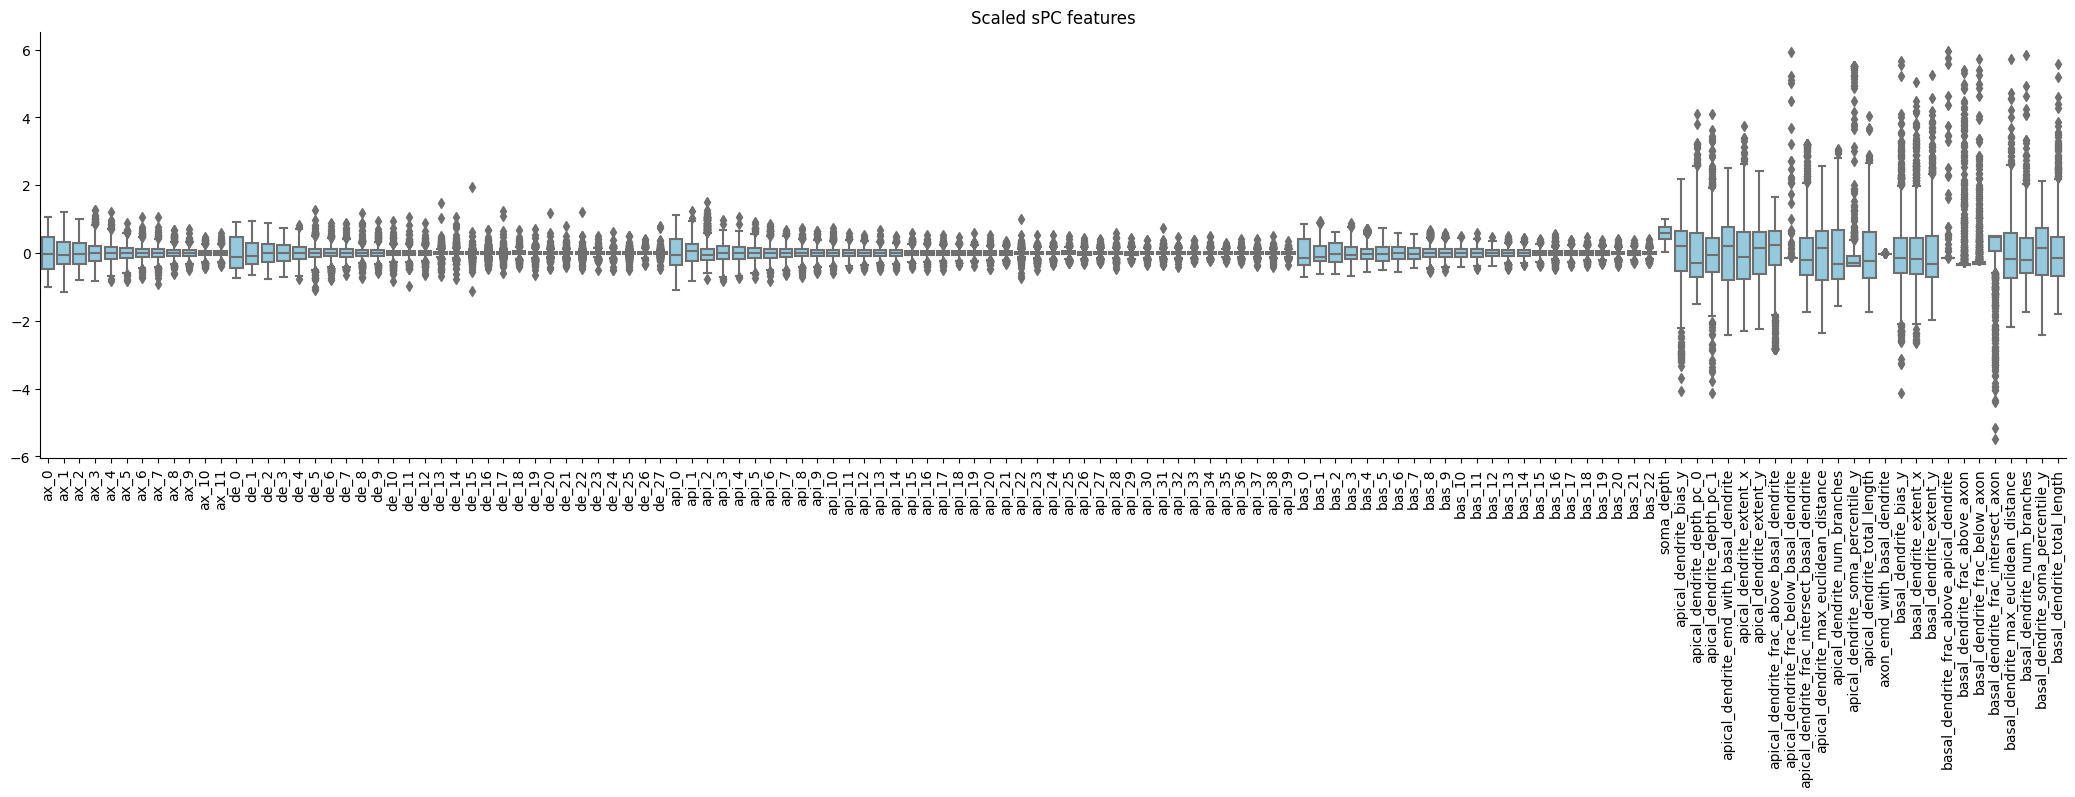

Size of Merged PCs features: (8643, 130)
Done


In [68]:
f = df_merged
df = f.melt(value_vars=f[[c for c in f.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value", kind='box', data=df, palette=sns.color_palette(["skyblue"]), aspect=4.4)
ax = plt.gca()
ax.set(**{'title': 'Scaled sPC features', 'xlabel': '', 'ylabel': ''})
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

print("Size of Merged PCs features:", df_merged.shape)
print("Done")

In [69]:
temp = df_merged[[c for c in df_merged.columns if c != "specimen_id"]]
temp.index[~temp.isna().all(1)]

Int64Index([   4,    8,   13,   15,   16,   18,   19,   20,   21,   23,
            ...
            8633, 8634, 8635, 8636, 8637, 8638, 8639, 8640, 8641, 8642],
           dtype='int64', length=2228)